reference: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
!pip install pycocotools

    100% |████████████████████████████████| 1.5MB 23.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for pycocotools ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/dc/e6/36/0e1ae88c868eb42d3f92181b1c9bbd0b217a7ec3da6bd62e55
Successfully built pycocotools
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
spacy 2.0.18 has requirement thinc<6.13.0,>=6.12.1, but you'll have thinc 6.12.0 which is incompatible.
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [25]:
from skimage import draw
import numpy as np
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [4]:
data_path = Path("../data/mapping/")

In [8]:
data_path.ls(), (data_path/'train').ls()

([PosixPath('../data/mapping/train')],
 [PosixPath('../data/mapping/train/annotation-small.json'),
  PosixPath('../data/mapping/train/images'),
  PosixPath('../data/mapping/train/annotation.json')])

In [40]:
from pycocotools import coco

In [41]:
coco = coco.COCO(data_path/'train/annotation-small.json')

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


In [44]:
len(coco.anns)

71871

### Prepare data for modeling

In [64]:
# there is only 1 category - building 
coco.cats

{100: {'id': 100, 'name': 'building', 'supercategory': 'building'}}

In [49]:
img_ids = (coco.getImgIds())

In [59]:
ann_ids = coco.getAnnIds()

In [60]:
len(ann_ids)

71871

In [74]:
from collections import defaultdict
from tqdm import tqdm_notebook
img2mask = defaultdict(int)

for ann_id in tqdm_notebook(ann_ids):
    ann = coco.anns[ann_id]
    img_id = ann['image_id']
    img2mask[img_id] += coco.annToMask(ann)

In [147]:
img_id = np.random.choice(img_ids)

8366 id:138329


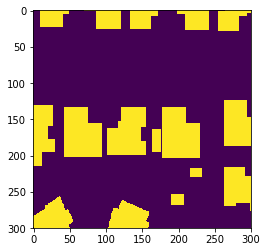

In [148]:
print(len(img2mask), f"id:{img_id}"); plt.imshow(img2mask[img_id]);

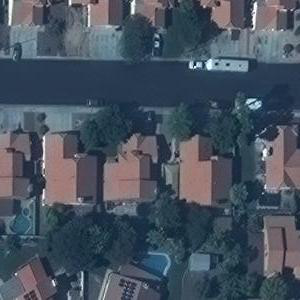

In [149]:
open_image(data_path/f'train/images/000000{img_id}.jpg')

In [97]:
# save the image masks 
def mask2pil(array):
    pil_img = PIL.Image.fromarray(array.astype(np.uint8)*255, mode='L')
    return pil_img

In [99]:
pil_img = mask2pil(img2mask[img_id])

In [107]:
os.makedirs(data_path/'train/labels', exist_ok=True)

In [116]:
images_path = data_path/'train/images/'; images_path

PosixPath('../data/mapping/train/images')

In [112]:
labels_path = data_path/'train/labels/'; labels_path

PosixPath('../data/mapping/train/labels')

In [123]:
for img_id in tqdm_notebook(img2mask):
    pil_img = mask2pil(img2mask[img_id])
    pil_img.save(labels_path/f"{img_id}.jpg")

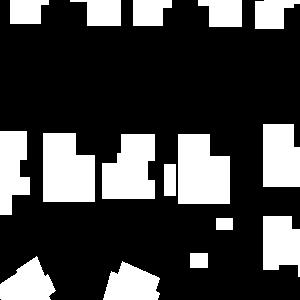

In [150]:
open_image(data_path/f'train/labels/{img_id}.jpg')

### Data

In [160]:
lbl_names = get_image_files(labels_path)
lbl_names[:3]

[PosixPath('../data/mapping/train/labels/247821.jpg'),
 PosixPath('../data/mapping/train/labels/259215.jpg'),
 PosixPath('../data/mapping/train/labels/276004.jpg')]

In [236]:
min([int(name.stem) for name in lbl_names])

95

In [240]:
sorted([int(name.stem) for name in fnames])

[95,
 109,
 178,
 185,
 201,
 204,
 205,
 229,
 270,
 288,
 408,
 413,
 435,
 455,
 501,
 547,
 565,
 577,
 583,
 596,
 617,
 667,
 682,
 713,
 715,
 807,
 900,
 925,
 955,
 970,
 976,
 1027,
 1032,
 1242,
 1246,
 1389,
 1400,
 1431,
 1455,
 1457,
 1589,
 1595,
 1645,
 1656,
 1696,
 1705,
 1708,
 1774,
 1875,
 1987,
 1994,
 2024,
 2056,
 2086,
 2110,
 2115,
 2243,
 2245,
 2292,
 2337,
 2393,
 2398,
 2422,
 2435,
 2443,
 2522,
 2572,
 2592,
 2619,
 2664,
 2686,
 2706,
 2742,
 2823,
 2906,
 2917,
 2924,
 2928,
 2985,
 2991,
 3001,
 3038,
 3072,
 3090,
 3161,
 3182,
 3203,
 3217,
 3288,
 3312,
 3317,
 3334,
 3350,
 3424,
 3457,
 3462,
 3474,
 3494,
 3502,
 3574,
 3584,
 3588,
 3622,
 3631,
 3641,
 3659,
 3662,
 3716,
 3719,
 3732,
 3738,
 3771,
 3847,
 3863,
 3926,
 3948,
 3977,
 4014,
 4047,
 4113,
 4159,
 4164,
 4223,
 4257,
 4263,
 4302,
 4355,
 4382,
 4397,
 4423,
 4431,
 4491,
 4524,
 4528,
 4556,
 4600,
 4715,
 4841,
 4866,
 4885,
 4886,
 4887,
 4900,
 4926,
 4948,
 4982,
 5010,
 50

In [162]:
def reverse_leftstrip(s, char='0', slen=12):
    while len(s) != slen: s = '0' + s
    return s

In [166]:
assert reverse_leftstrip('131011') == '000000131011'

In [168]:
img_f.parent

PosixPath('../data/mapping/train/images')

In [238]:
fnames = [Path(f"{images_path}/{reverse_leftstrip(fname.stem)}{fname.suffix}") for fname in lbl_names]
fnames[:3]

[PosixPath('../data/mapping/train/images/000000247821.jpg'),
 PosixPath('../data/mapping/train/images/000000259215.jpg'),
 PosixPath('../data/mapping/train/images/000000276004.jpg')]

In [181]:
assert len(fnames) == len(lbl_names)

../data/mapping/train/images/000000094596.jpg


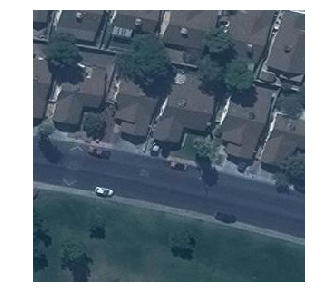

In [214]:
img_f = fnames[10]; print(img_f)
img = open_image(img_f)
img.show(figsize=(5,5))

In [215]:
def stripleft(s, char='0'): 
    i = 0
    while s[i] == '0': i += 1
    return s[i:]

In [249]:
def get_y_fn(x):
    x = Path(x)
    return labels_path/f'{stripleft(x.stem)}{x.suffix}'

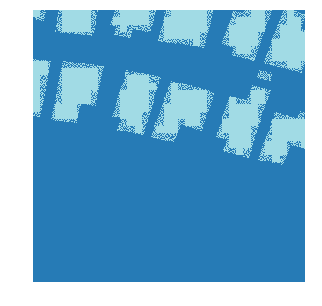

In [217]:
mask = open_mask(get_y_fn(img_f), div=True)
mask.show(figsize=(5,5), alpha=10)

In [218]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([300, 300]), tensor([[[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [219]:
codes = ['Background', 'Building']

### Datasets

In [279]:
size = src_size//2
bs=8

In [280]:
size

array([150, 150])

In [281]:
len(fnames), len(lbl_names)

(8366, 8366)

In [282]:
images_df = pd.DataFrame({"Image":[fname.name for fname in fnames]})

In [314]:
src = (SegmentationItemList.from_df(images_df, path=data_path/"train/images", cols=["Image"])
       .random_split_by_pct()
       .label_from_func(get_y_fn, classes=codes))

In [324]:
SegmentationLabelList.open = partial(open_mask, div=True)

In [325]:
data = (src.transform(get_transforms(True, True, max_warp=0), size=150, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

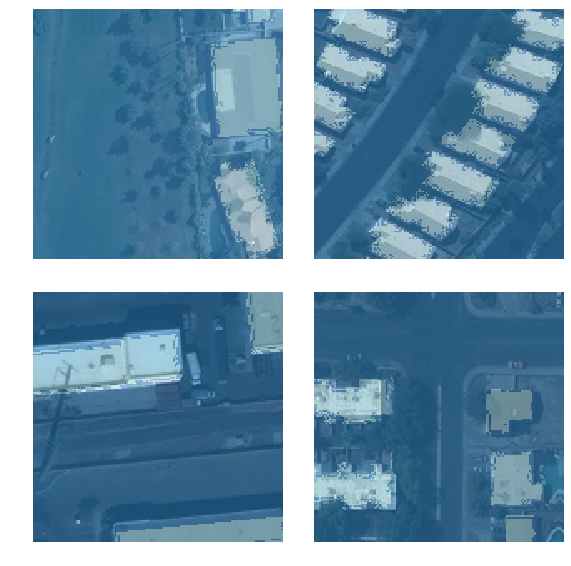

In [326]:
data.show_batch(rows=2, alpha=1.5)

### Model

In [328]:
wd = 1e-2
learn = unet_learner(data, models.resnet34, metrics=[], wd=wd)

In [329]:
xb,yb = learn.data.one_batch()

In [330]:
out = learn.model(xb.cuda())

In [346]:
def accuracy(input, target):
    return torch.mean((torch.argmax(input, dim=1).view(-1)== 
                      target.squeeze(1).view(-1)).float() )

In [347]:
accuracy(out, yb.cuda())

tensor(0.2355, device='cuda:0')

In [348]:
learn.metrics = [accuracy]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


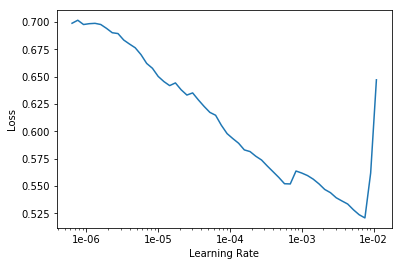

In [349]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(1e-3), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,0.246145,0.223985,0.907809
